In [5]:
import os
import sys; sys.path.append(os.path.abspath('..'))

from src.environment import WarehouseEnv
from src.planning.fsm_planner import FSMAutomaton
from src.utils.visualization import EnvironmentVisualizer
import yaml
from src.utils.buffer import ReplayBuffer

with open("../config/warehouse_v1.yaml", 'r') as f:
    config = yaml.safe_load(f)
env = WarehouseEnv(config)
fsm = FSMAutomaton(start_pos = config['fsm']['start_state'], goal_pos = config['fsm']['goal_state'], config=config)

In [2]:
env.env_config

{'workspace': [12.0, 10.0],
 'dt': 0.1,
 'v_max': 1.5,
 'a_max': 3.0,
 'omega_max': 1.57,
 'robot_radius': 0.15}

In [11]:
fsm.transitions

{'START': ['WAYPOINT_1'], 'WAYPOINT_1': ['GOAL'], 'GOAL': []}

(<Figure size 1400x1200 with 1 Axes>,
 <Axes: xlabel='X Position (meters)', ylabel='Y Position (meters)'>)

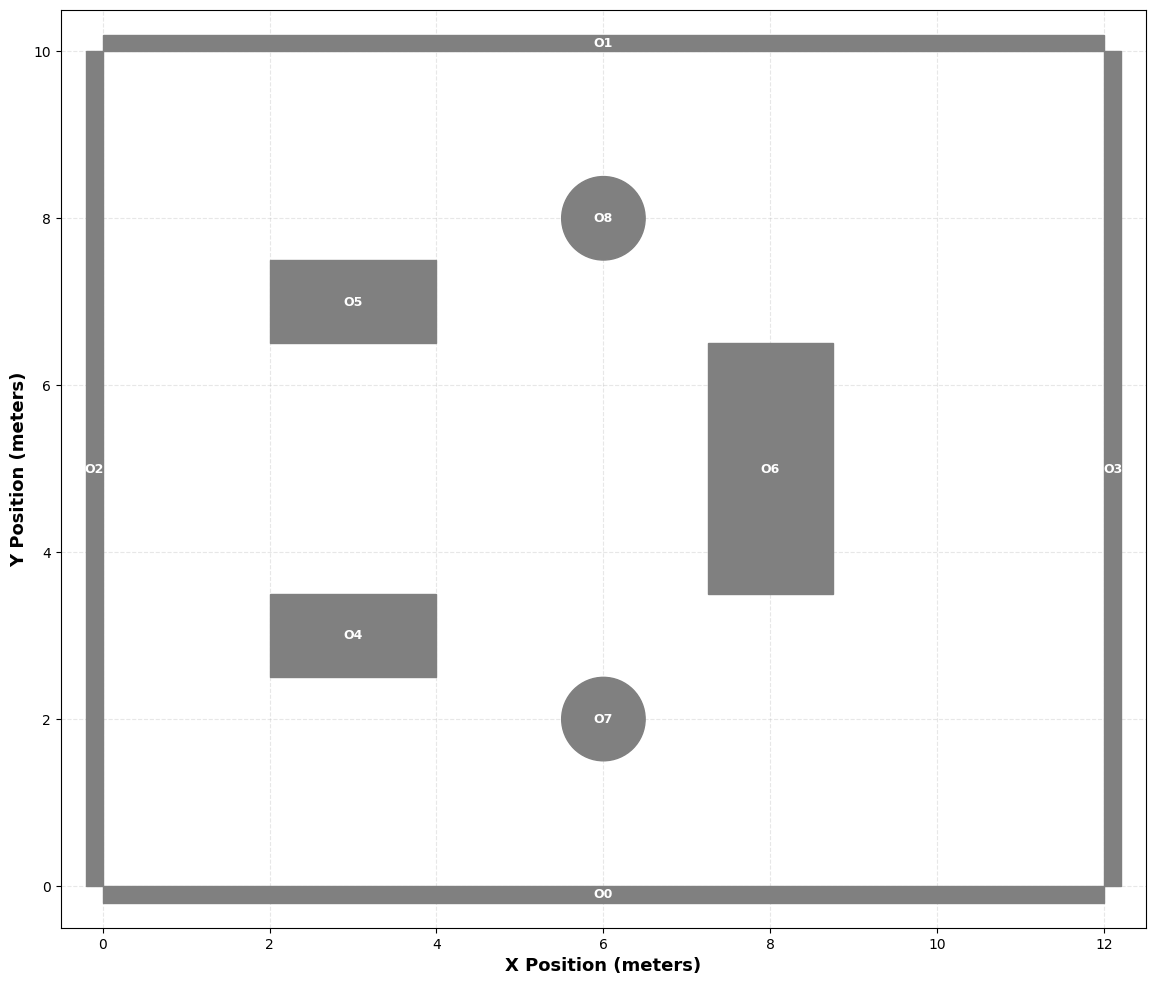

In [4]:
ev = EnvironmentVisualizer(env)
ev.plot_environment()

In [ ]:
nn_config = config['nn']
gen_config = config['data_gen']

buffer = ReplayBuffer(
    state_dim=nn_config['state_dim'],
    action_dim=nn_config['action_dim'],
    subgoal_dim=nn_config['subgoal_dim'],
    max_size=gen_config['num_transitions']
)

print(buffer.__len__())


0


=== Data Inspection: ../data/pretrain_data.pkl ===

Total transitions: 30000
State dimension: 5
Action dimension: 2
Subgoal dimension: 2

=== Safety Statistics ===
Safe states (h* > 0): 23565 (78.5%)
Unsafe states (h* <= 0): 6435 (21.4%)
Collisions (done=True): 6435 (21.4%)

=== Value Statistics ===
h* (safety): min=-0.173, max=1.809, mean=0.305
v* (feasibility): min=0.001, max=179.428, mean=39.469

=== Subgoal Distribution ===
Unique subgoals: 2
  Subgoal 1: [6. 5.] (10043 samples, 33.5%)
  Subgoal 2: [10.5  8.5] (19957 samples, 66.5%)


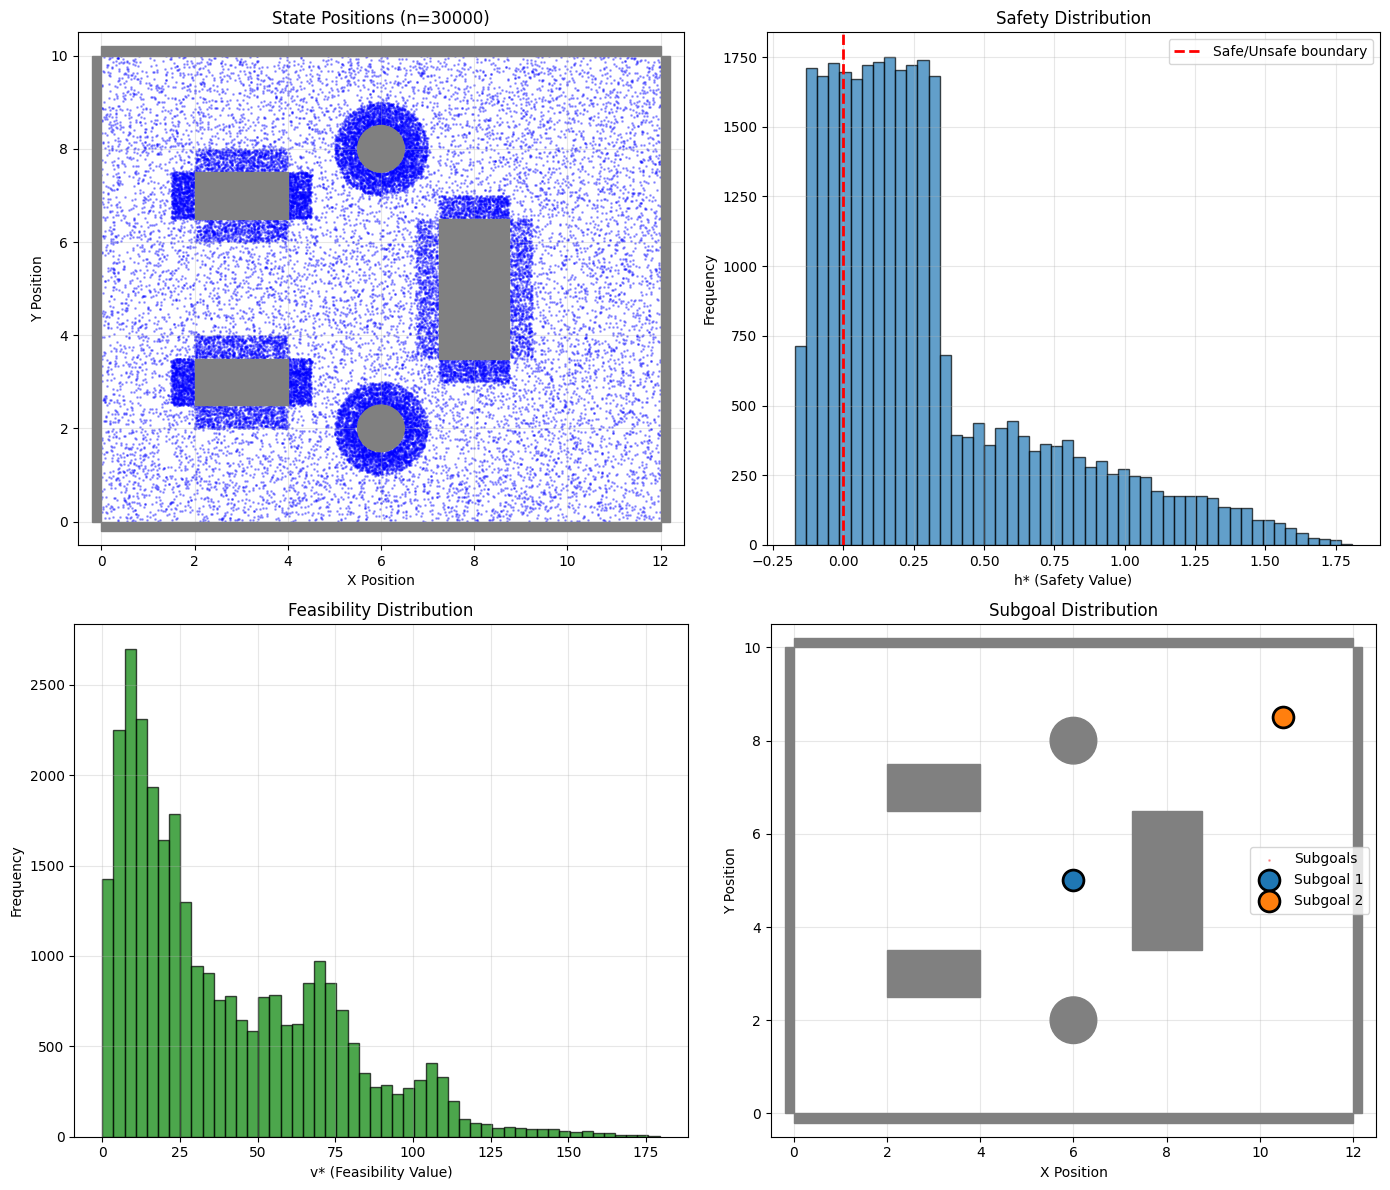


=== Sample Transitions ===

Transition 8511:
  State: [5.33, 1.46, ...]
  Action: [-1.601, -0.233]
  Next State: [5.33, 1.46, ...]
  Subgoal: [10.50, 8.50]
  h* (safety): 0.212 (SAFE)
  v* (feasibility): 76.333
  Done: 0.0

Transition 18154:
  State: [9.63, 0.60, ...]
  Action: [2.246, -1.551]
  Next State: [9.64, 0.62, ...]
  Subgoal: [10.50, 8.50]
  h* (safety): 0.472 (SAFE)
  v* (feasibility): 62.798
  Done: 0.0

Transition 24780:
  State: [2.38, 2.04, ...]
  Action: [-2.784, 0.880]
  Next State: [2.38, 2.04, ...]
  Subgoal: [10.50, 8.50]
  h* (safety): 0.314 (SAFE)
  v* (feasibility): 107.656
  Done: 0.0

Transition 2624:
  State: [4.28, 2.71, ...]
  Action: [0.179, -1.084]
  Next State: [4.28, 2.71, ...]
  Subgoal: [10.50, 8.50]
  h* (safety): 0.134 (SAFE)
  v* (feasibility): 72.161
  Done: 0.0

Transition 27211:
  State: [4.01, 7.35, ...]
  Action: [0.528, 0.962]
  Next State: [4.01, 7.34, ...]
  Subgoal: [6.00, 5.00]
  h* (safety): -0.138 (UNSAFE)
  v* (feasibility): 9.445
  Do

In [11]:
# now let's inspect the data generated in pretrain_data.pkl 
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the pretrain data directly from pickle file
data_path = "../" + config['data_gen']['data_path']
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Extract data arrays
states = data['states']
actions = data['actions']
next_states = data['next_states']
subgoals = data['subgoals']
rewards = data['rewards']
dones = data['dones']
h_stars = data['h_stars']
v_stars = data['v_stars']

num_transitions = len(states)

print(f"=== Data Inspection: {data_path} ===\n")
print(f"Total transitions: {num_transitions}")
print(f"State dimension: {states.shape[1]}")
print(f"Action dimension: {actions.shape[1]}")
print(f"Subgoal dimension: {subgoals.shape[1]}\n")

# Basic statistics
print("=== Safety Statistics ===")
safe_count = np.sum(h_stars > 0)
unsafe_count = np.sum(h_stars <= 0)
collision_count = np.sum(dones > 0)
print(f"Safe states (h* > 0): {safe_count} ({100*safe_count/num_transitions:.1f}%)")
print(f"Unsafe states (h* <= 0): {unsafe_count} ({100*unsafe_count/num_transitions:.1f}%)")
print(f"Collisions (done=True): {collision_count} ({100*collision_count/num_transitions:.1f}%)\n")

print("=== Value Statistics ===")
print(f"h* (safety): min={h_stars.min():.3f}, max={h_stars.max():.3f}, mean={h_stars.mean():.3f}")
print(f"v* (feasibility): min={v_stars.min():.3f}, max={v_stars.max():.3f}, mean={v_stars.mean():.3f}\n")

# Subgoal distribution
print("=== Subgoal Distribution ===")
subgoals_unique = np.unique(subgoals, axis=0)
print(f"Unique subgoals: {len(subgoals_unique)}")
for i, sg in enumerate(subgoals_unique):
    count = np.sum(np.all(subgoals == sg, axis=1))
    print(f"  Subgoal {i+1}: {sg} ({count} samples, {100*count/num_transitions:.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. State positions
ax = axes[0, 0]
positions = states[:, :2]  # x, y positions
ax.scatter(positions[:, 0], positions[:, 1], alpha=0.3, s=1, c='blue')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title(f'State Positions (n={num_transitions})')
ax.set_xlim(-0.5, env.workspace[0] + 0.5)
ax.set_ylim(-0.5, env.workspace[1] + 0.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
# Overlay obstacles
for obs in env.obstacles:
    obs.plot(ax)

# 2. Safety distribution (h*)
ax = axes[0, 1]
h_stars_flat = h_stars.flatten()
ax.hist(h_stars_flat, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Safe/Unsafe boundary')
ax.set_xlabel('h* (Safety Value)')
ax.set_ylabel('Frequency')
ax.set_title('Safety Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Feasibility distribution (v*)
ax = axes[1, 0]
v_stars_flat = v_stars.flatten()
ax.hist(v_stars_flat, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('v* (Feasibility Value)')
ax.set_ylabel('Frequency')
ax.set_title('Feasibility Distribution')
ax.grid(True, alpha=0.3)

# 4. Subgoal positions
ax = axes[1, 1]
subgoal_positions = subgoals[:, :2]
ax.scatter(subgoal_positions[:, 0], subgoal_positions[:, 1], alpha=0.3, s=1, c='red', label='Subgoals')
# Show unique subgoals
for i, sg in enumerate(subgoals_unique):
    ax.plot(sg[0], sg[1], 'o', markersize=15, markeredgecolor='black', 
            markeredgewidth=2, label=f'Subgoal {i+1}' if i < 5 else '')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Subgoal Distribution')
ax.set_xlim(-0.5, env.workspace[0] + 0.5)
ax.set_ylim(-0.5, env.workspace[1] + 0.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend()
# Overlay obstacles
for obs in env.obstacles:
    obs.plot(ax)

plt.tight_layout()
plt.show()

# Sample transitions
print("\n=== Sample Transitions ===")
sample_indices = np.random.choice(num_transitions, min(5, num_transitions), replace=False)
for idx in sample_indices:
    s = states[idx]
    a = actions[idx]
    s_next = next_states[idx]
    g = subgoals[idx]
    h_star_val = h_stars[idx][0]
    v_star_val = v_stars[idx][0]
    done = dones[idx][0]
    
    print(f"\nTransition {idx}:")
    print(f"  State: [{s[0]:.2f}, {s[1]:.2f}, ...]")
    print(f"  Action: [{a[0]:.3f}, {a[1]:.3f}]")
    print(f"  Next State: [{s_next[0]:.2f}, {s_next[1]:.2f}, ...]")
    print(f"  Subgoal: [{g[0]:.2f}, {g[1]:.2f}]")
    print(f"  h* (safety): {h_star_val:.3f} {'(SAFE)' if h_star_val > 0 else '(UNSAFE)'}")
    print(f"  v* (feasibility): {v_star_val:.3f}")
    print(f"  Done: {done}")
